# Bayesian Bandits
In this notebook we'll go through a simple implementation of bayesian bandits.

The setting is that we're faced with a number of bandit machines. They all have a different probability of yielding a jackpot, but we don't know which one is the best. At each step we choose one arm to pull, observe the result and collect the reward if any. The goal is to maximize our reward, but there's a bit of exploration and exploitation to trade off. We want to pull arms more or less at random at the beginning to get as much information as possible and then pull more and more frequently on the bandits which we think are best. 

In this notebook we implement two agents: 
* a RandomAgent which just takes actions at random 
* a BayesianAgent which 
   * keeps a posterior distribution for each bandit updated
   * at each step draws a probability from the posteriors and chooses the bandit with the highest drwan probability. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We'll make sa simple bandit environment, mimicking the OpenAI gym interface.

In [2]:
class BanditEnv:
    def __init__(self, n):
        self.actions = np.arange(n)
        self.probs = np.random.random(n)
    def step(self, action: int):
        return np.random.binomial(n=1, p=self.probs[action])

We create an environment with just one bandit and check that the probability and sample mean are close

In [4]:
env = BanditEnv(1)

In [6]:
rewards = []
for i in range(1000):
    rewards.append(env.step(0))
print("mean reward: ", np.mean(rewards))
print("bandit probability: ", env.probs[0])

mean reward:  0.625
bandit probability:  0.5985785801165487


Now we implement our random agent and let it do 10000 steps in a bandit environment with 10 bandits.

In [7]:
class RandomAgent:
    def __init__(self, n):
        self.n = n
    def choose_bandit(self):
        return np.random.randint(0, self.n)

In [8]:
n_bandits = 10
env = BanditEnv(n_bandits)
rand_agent = RandomAgent(n_bandits)

Text(0.5, 1.0, 'Cumulative rewards of random agent')

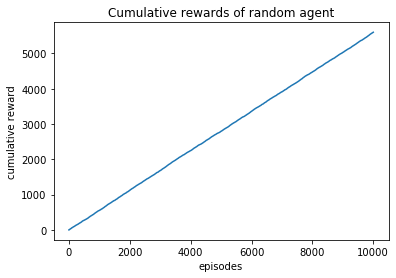

In [12]:
sims = 10000
rewards = np.zeros(sims)
for i in range(sims):
    action = rand_agent.choose_bandit()
    rewards[i] = env.step(action)
plt.plot(np.cumsum(rewards))
plt.xlabel('episodes')
plt.ylabel('cumulative reward')
plt.title("Cumulative rewards of random agent")

Next we implement the BayesianAgent and check that it outperforms the RandomAgent. 

In [28]:
from scipy.stats import beta
class BayesianAgent:
    def __init__(self, n):
        self.n = n
        self.posterior_params = [{"a": 1, "b":1} for i in range(n)]
    def choose_bandit(self):
        #sample from posteriors
        posteriors_samples = [beta.rvs(self.posterior_params[i]["a"], self.posterior_params[i]["b"]) for i in range(self.n)]
        action = np.argmax(posteriors_samples)
        return action
    def update_posterior(self, i, observation):
        if observation==1:
            self.posterior_params[i]["a"]+=1
        else:
            self.posterior_params[i]["b"]+=1

In [29]:
bb = BayesianAgent(n_bandits)

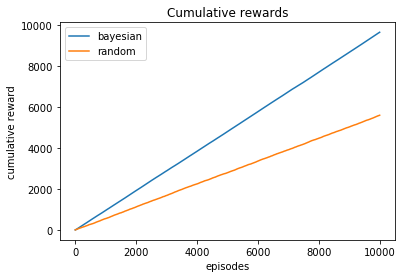

In [30]:
sims = 10000
rewards_bayesian = np.zeros(sims)
for i in range(sims):
    action = bb.choose_bandit()
    reward = env.step(action)
    bb.update_posterior(action, reward)
    rewards_bayesian[i] = reward
plt.plot(np.cumsum(rewards_bayesian), label="bayesian")
plt.plot(np.cumsum(rewards), label="random")
plt.xlabel('episodes')
plt.ylabel('cumulative reward')
plt.title("Cumulative rewards")
plt.legend();